###### General Steps to Follow
1. Importing Packages
1. Setup Mediapipe
1. Some Data Preprocessing of The Input Video before Using DTW
1. DTW Analysis

# ------------------------------------------------------------------------------------------------------------

## 1) Importing Packages

In [1]:
import os
import sys
REPO_DIR_PATH = os.path.normpath(os.path.join(
    os.path.join(os.getcwd(), "..")))
sys.path.append(REPO_DIR_PATH)

In [2]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from src.data_preprocessing.data_transformation import DataTransformer
from scipy.signal import medfilt
from scipy.signal import find_peaks
import numpy as np
from datetime import datetime

2024-04-17 12:24:48.311981: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 12:24:48.960107: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# ------------------------------------------------------------------------------------------------------------

## 2) Setup Mediapipe

In [3]:
# Setup mediapipe instance
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [4]:
pose_model = mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)

I0000 00:00:1713349490.145414   22376 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713349490.180337   22454 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2


###                                                              MediaPipe Poses
<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

# ------------------------------------------------------------------------------------------------------------

## 3) Some Data Preprocessing of The Input Video before Using DTW

#### 1- Get frames and angles from the video

In [5]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [14]:
def get_video_frames_and_angles(video_source):
    cap = cv2.VideoCapture(video_source)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 960)
    frames = []
    angles = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        results = pose_model.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Extract landmarks
        if results.pose_landmarks == None:
            continue
        landmarks = results.pose_landmarks.landmark

        # Get coordinates
        shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
        wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

        # Calculate angle
        angle = calculate_angle(shoulder, elbow, wrist)
        angles.append(angle)

        # Visualize angle
        height, width, _ = image.shape
        cv2.putText(image, str(round(angle,2)), 
                       tuple(np.multiply(elbow, [width+40, height+20]).astype(int)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

        # Rep data
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )
        frame = cv2.flip(frame,1)
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
            
    return frames, angles

#### 2- Apply median filter to the angles

In [40]:
def MedianFilter(angles):
    window_size = 31
    # Apply median filter to the angles_series
    denoised_angles = medfilt(angles, kernel_size=window_size)
    return denoised_angles
def MedianFilter(angles,window_size):
    # Apply median filter to the angles_series
    denoised_angles = medfilt(angles, kernel_size=window_size)
    return denoised_angles

#### 3- Get the peaks and troughs

In [8]:
def get_peaks_and_troughs(angles):
    peaks, _ = find_peaks(angles, prominence=0.1)  # Adjust prominence threshold as needed
    troughs, _ = find_peaks(-angles, prominence=0.1)  # Find troughs by negating the angle data
    return peaks, troughs

#### 4- Get the cycles by deviding the frames according to the increasing/decreasing in the angles (peaks/troughs)

In [9]:
def get_cycles(frames, peaks):
    cycles = []
    for peak_index in range(len(peaks)-1):
        cycle = []
        cnt = peaks[peak_index]
        while True:
            cycle.append(frames[cnt])
            if cnt == peaks[peak_index+1]:
                break
            cnt+=1
        cycles.append(cycle)
    return cycles

#### 5- Convert each cycle to sequential data

In [10]:
obj = DataTransformer("bicep","poses")
def get_sequential_data(cycles):
    seq_data = []
    for cycle in cycles:
        seq = []
        for frame in cycle:
            poses = obj.get_frame_poses(frame)
            if poses == None:
                continue
            seq.append(poses)
        seq_data.append(np.array(seq))
    return seq_data

I0000 00:00:1713349493.236019   22376 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713349493.263013   22471 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2


In [143]:
def determine_window_size(angles):
    # Find peaks and valleys in the data
    angles = np.array(angles)
    peaks_indices, _ = find_peaks(angles)
    valleys_indices, _ = find_peaks(-angles)

    # Compute distances between consecutive peaks
    distances = np.diff(peaks_indices)

    # Choose initial window size based on median distance
    initial_window_size = np.median(distances)

    # Adjust window size based on specific requirements
    adjusted_window_size = initial_window_size * 1

    return adjusted_window_size


In [31]:
def save_cycle_frames_as_video(cycle_frames, output_path, fps=20):
    """
    Save a list of frames as a video file.
    input:
        cycle_frames(list): List of frames
        output_path(str): Output video file path
        fps(int): Frames per second
    output:
        None
    """
    try:
        # Get the shape of the first frame to determine video dimensions
        height, width, _ = cycle_frames[0].shape

        # Define the codec and create VideoWriter object
        # Choose the codec (here, MP4V)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        try:
            # Write each frame to the video file
            for frame in cycle_frames:
                out.write(frame)
        finally:
            # Release the VideoWriter object
            out.release()
    except Exception as e:
        logging.error("Error: "+str(e))
        raise CustomException(e, sys)

def save_cycles_as_videos(cycles: list):
    """
    This function will save the cycles as videos in the output directory.
    input:
        cycles(list): List of cycles
        video_name(str): Video name
    output:
        None
    """
    video_name = str(datetime.now().strftime('%Y-%m-%d-%I-%M-%S'))
    output_dir = os.path.normpath(os.path.join(
    os.path.join(os.getcwd(), "..","results","cycles_divider",video_name)))
    # Check if the directory already exists
    if not os.path.exists(output_dir):
        # Create the directory
        os.makedirs(output_dir)
    for i, cycle in enumerate(cycles):
        output_path = os.path.join(
            output_dir, video_name+"_cycle"+str(i+1)+".mp4")
        save_cycle_frames_as_video(cycle, output_path)

In [155]:

def exponential_moving_average(data, alpha):
    ema = [data[0]]  # Initial value is the same as the first data point
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[i-1])
    return np.array(ema)


In [178]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def smooth_with_lowess(x, y, frac=0.1):
    """
    Apply Lowess smoothing to the input data.

    Parameters:
        x (array-like): Independent variable.
        y (array-like): Dependent variable.
        frac (float): Fraction of data points to use in each local regression (0 < frac < 1).

    Returns:
        ndarray: Smoothed values.
    """
    smooth_result = lowess(y, x, frac=frac)
    return smooth_result[:, 1]


In [191]:
def hampel_filter(data, window_size=3, n_sigma=3):
    """
    Apply the Hampel filter to the input data.

    Parameters:
        data (array-like): Input data to be smoothed.
        window_size (int): Size of the window (number of data points).
        n_sigma (float): Number of standard deviations to use for outlier detection.

    Returns:
        ndarray: Smoothed values.
    """
    data = np.asarray(data)
    n = len(data)
    smoothed_data = np.zeros(n)

    for i in range(n):
        lower_bound = max(0, i - window_size)
        upper_bound = min(n, i + window_size + 1)
        window = data[lower_bound:upper_bound]
        median = np.nanmedian(window)
        deviation = np.abs(window - median)
        mad = np.nanmedian(deviation)
        if np.abs(data[i] - median) > n_sigma * mad:
            smoothed_data[i] = median
        else:
            smoothed_data[i] = data[i]

    return smoothed_data

In [199]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff_freq, fs, order=5):
    """
    Apply a low-pass Butterworth filter to the input data.

    Parameters:
        data (array-like): Input data to be smoothed.
        cutoff_freq (float): Cutoff frequency of the filter (in Hz).
        fs (float): Sampling frequency of the data (in Hz).
        order (int): Order of the filter.

    Returns:
        ndarray: Smoothed values.
    """
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [130]:
def data_preprocessing(video_source):
    frames, angles = get_video_frames_and_angles(video_source)
    denoised_angles = MedianFilter(angles,41)
    peaks, troughs = get_peaks_and_troughs(denoised_angles)
    cycles = get_cycles(frames, peaks)
    #seq_data = get_sequential_data(cycles)
    seq_data = None
    return frames, angles, denoised_angles, peaks, troughs, cycles, seq_data

#### Testing the functions

In [289]:
video_source = 0
#video_source = "../data/external/self_collected_data/bicep/criteria_1/1/12B.mp4"
frames, angles, denoised_angles, peaks, troughs, cycles, seq_data = data_preprocessing(video_source)

In [239]:
len(cycles)

7

In [144]:
determine_window_size(angles)

5.0

In [133]:
# will be saved at results/cycles_divider
save_cycles_as_videos(cycles)

In [290]:
#denoised_angles = MedianFilter(angles,61)
frame_numbers = np.arange(len(angles))
angles_arr = np.array(angles)  # Your angles data
# Define filter parameters
cutoff_freq = 5.0  # Adjust this value based on your data
fs = 50.0  # Sampling frequency (Hz)
denoised_angles =  butter_lowpass_filter(angles_arr, cutoff_freq, fs, order=5)
denoised_angles = MedianFilter(denoised_angles,11)
peaks, troughs = get_peaks_and_troughs(denoised_angles)
cycles = get_cycles(frames, peaks)
save_cycles_as_videos(cycles)

#### Plotting Angles Over Frames

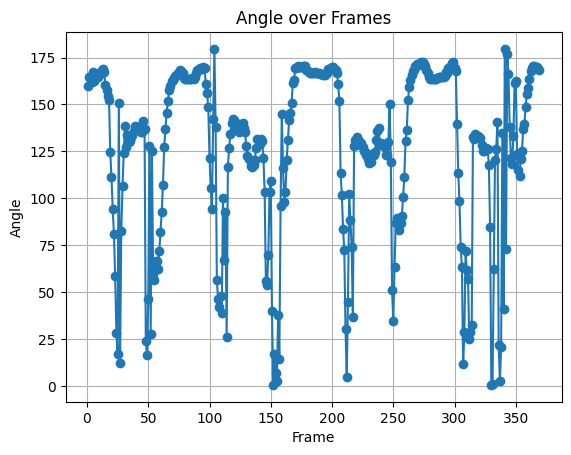

In [260]:
frames_index = []
for i in range(1,len(angles)+1):
    frames_index.append(i)
plt.plot(frames_index, angles, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Angle over Frames')

# Show grid
plt.grid(True)

# Show plot
plt.show()

#### Plotting Peaks and Troughs

Text(0.5, 1.0, 'Angles Series with Peaks and Troughs')

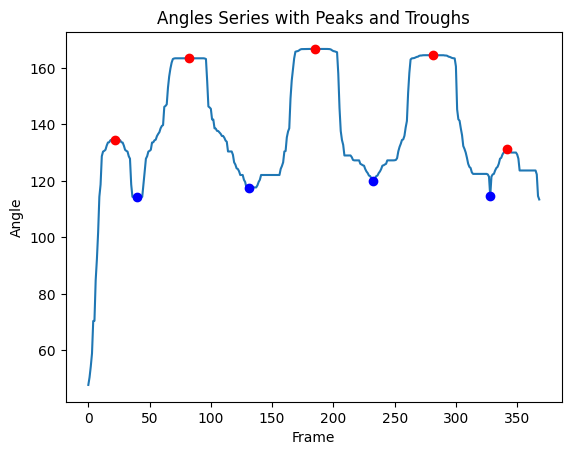

In [261]:
# Plot the angle series
plt.plot(denoised_angles, label='Angle Series')

# Plot peaks and troughs
plt.plot(peaks, denoised_angles[peaks], 'ro', label='Peaks')
plt.plot(troughs, denoised_angles[troughs], 'bo', label='Troughs')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Angles Series with Peaks and Troughs')

In [46]:
peaks, troughs

(array([ 13,  37,  86, 125, 158, 190, 225, 257, 288]),
 array([ 27,  64, 106, 139, 174, 208, 242, 274, 300]))

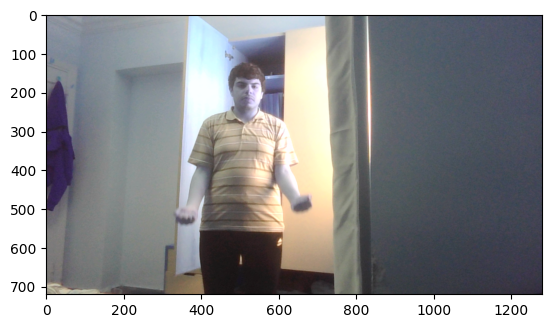

In [48]:
plt.imshow(frames[250])

### Trying other techniques

In [66]:
import numpy as np
from scipy import stats
from scipy.signal import savgol_filter

In [82]:
def smooth_data(data):
    # Assuming 'data' is your noisy data
    data = np.array(data)
    window_length = 5  # Window length for smoothing
    poly_order = 2     # Order of the polynomial to fit

    smoothed_data = savgol_filter(data, window_length, poly_order)

In [108]:


# Assuming 'angles' is your angle data
smoothed_angles = MedianFilter(angles,41)  # Apply smoothing technique

# Calculate z-scores
z_scores = np.abs(stats.zscore(smoothed_angles))

# Define a threshold (e.g., z-score > 3 is considered an outlier)
threshold = 3.0

filtered_angles = []
# Remove outliers
for z_score, angle in zip(z_scores, smoothed_angles):
    if z_score < threshold:
        filtered_angles.append(angle)

# Convert filtered_angles to a numpy array if needed
filtered_angles = np.array(filtered_angles)


In [125]:
frames_index = []
for i in range(1,len(angles)+1):
    frames_index.append(i)
plt.plot(frames_index, angles, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Angle over Frames')

# Show grid
plt.grid(True)

# Show plot
plt.show()

TypeError: object of type 'ellipsis' has no len()

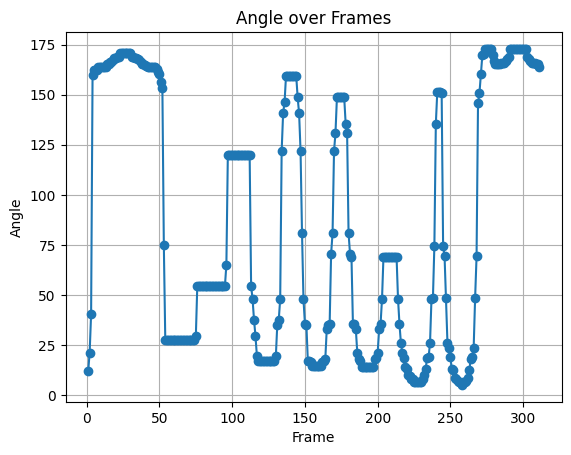

In [110]:
frames_index = []
for i in range(1,len(smoothed_angles)+1):
    frames_index.append(i)
plt.plot(frames_index, smoothed_angles, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Angle over Frames')

# Show grid
plt.grid(True)

# Show plot
plt.show()

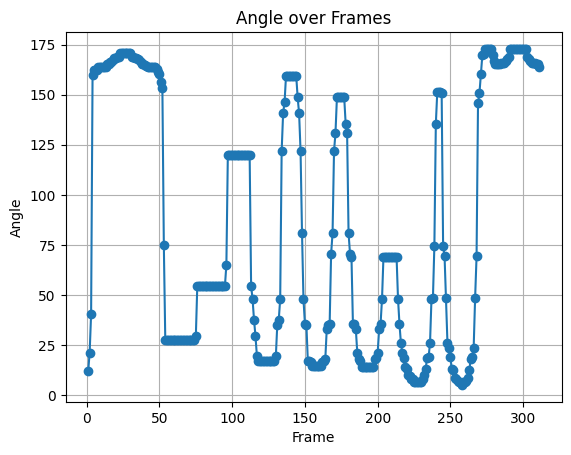

In [111]:
frames_index = []
for i in range(1,len(filtered_angles)+1):
    frames_index.append(i)
plt.plot(frames_index, filtered_angles, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Angle over Frames')

# Show grid
plt.grid(True)

# Show plot
plt.show()

In [123]:
import numpy as np
from scipy.signal import savgol_filter

# Step 1: Detect Outliers (Example using z-scores)
z_scores = np.abs(stats.zscore(angles))
threshold = 3  # Adjust this threshold as needed
outlier_indices = np.where(z_scores > threshold)[0]

# Step 2: Filter Out Outliers
filtered_angles = np.delete(angles, outlier_indices)

# Step 3: Smooth Data (Example using Savitzky-Golay filtering)
smoothed_angles = savgol_filter(filtered_angles, window_length=11, polyorder=3)

# Plot the original and smoothed data to visualize the effect
import matplotlib.pyplot as plt
plt.plot(angles, label='Original')
plt.plot(smoothed_angles, label='Smoothed')
plt.legend()
plt.show()


AxisError: axis 0 is out of bounds for array of dimension 0

Ellipsis

# ------------------------------------------------------------------------------------------------------------

## 4) DTW Analysis

In [39]:
def euclidean_distance(v1, v2):
    """
    Compute the Euclidean distance between two vectors.
    
    Parameters:
        v1 (numpy.ndarray): First vector.
        v2 (numpy.ndarray): Second vector.
        
    Returns:
        float: Euclidean distance between the two vectors.
    """
    return np.linalg.norm(v1 - v2)

def dtw_distance(s1, s2):
    """
    Compute the Dynamic Time Warping (DTW) distance between two sequences of vectors.
    
    Parameters:
        s1 (numpy.ndarray): First sequence of vectors (2D array).
        s2 (numpy.ndarray): Second sequence of vectors (2D array).
        
    Returns:
        float: DTW distance between the two sequences.
    """
    # Calculate the length of each sequence
    n, m = len(s1), len(s2)
    
    # Initialize the DTW matrix with zeros
    dtw_matrix = np.zeros((n + 1, m + 1))
    
    # Fill the first row and column of the matrix with infinity
    dtw_matrix[0, 1:] = np.inf
    dtw_matrix[1:, 0] = np.inf
    
    # Calculate the DTW matrix
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = euclidean_distance(s1[i - 1], s2[j - 1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i - 1, j], dtw_matrix[i, j - 1], dtw_matrix[i - 1, j - 1])
    
    # Return the DTW distance
    return dtw_matrix[n, m]

#### 1- Load some reference sequential data

In [42]:
def load_some_reference_seq_data():
    video_source = "../data/external/self_collected_data/bicep/criteria_1/0/4.mp4"
    reference_frames, reference_angles, reference_denoised_angles, reference_peaks, reference_troughs, reference_cycles, reference_seq_data = data_preprocessing(video_source)
    return reference_frames, reference_angles, reference_denoised_angles, reference_peaks, reference_troughs, reference_cycles, reference_seq_data

In [43]:
reference_frames, reference_angles, reference_denoised_angles, reference_peaks, reference_troughs, reference_cycles, reference_seq_data = load_some_reference_seq_data()

In [44]:
len(reference_seq_data)

5

In [45]:
reference_peaks

array([ 18,  46,  79, 112, 145, 176])

##### Plotting Peaks and Troughs

Text(0.5, 1.0, 'Angles Series with Peaks and Troughs of the Refrence Data')

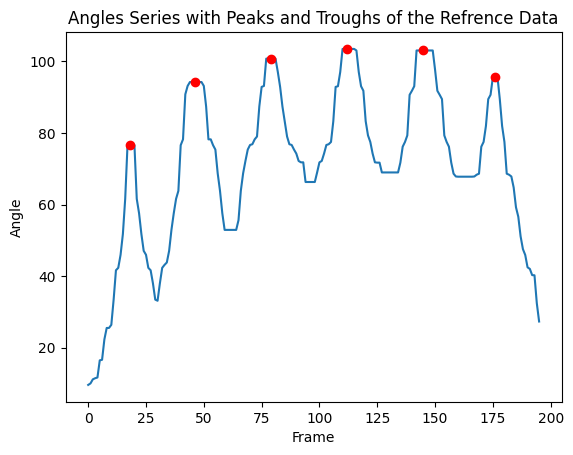

In [46]:
# Plot the angle series
plt.plot(reference_denoised_angles, label='Angle Series')

# Plot peaks and troughs
plt.plot(reference_peaks, reference_denoised_angles[reference_peaks], 'ro', label='Peaks')
#plt.plot(troughs, denoised_angles[troughs], 'bo', label='Troughs')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Angles Series with Peaks and Troughs of the Refrence Data')

#### 2- Get the sequential data of the input video

In [76]:
#video_source = "../data/external/self_collected_data/bicep/criteria_1/1/7B.mp4"
video_source = 0
frames, angles, denoised_angles, peaks, troughs, cycles, seq_data = data_preprocessing(video_source)

In [77]:
len(seq_data)

7

##### Plotting Peaks and Troughs

Text(0.5, 1.0, 'Angles Series with Peaks and Troughs')

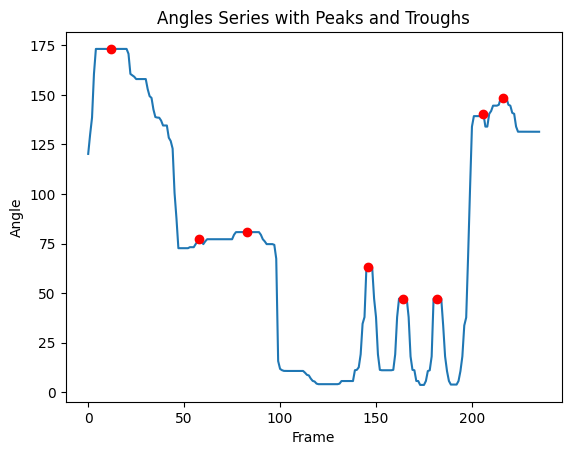

In [78]:
# Plot the angle series
plt.plot(denoised_angles, label='Angle Series')

# Plot peaks and troughs
plt.plot(peaks, denoised_angles[peaks], 'ro', label='Peaks')
#plt.plot(troughs, denoised_angles[troughs], 'bo', label='Troughs')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Angles Series with Peaks and Troughs')

#### 3- Calculating the DTW distances

In [83]:
input_cycle_number = 5
ref_index = 3
dtw_distance(seq_data[input_cycle_number-1], reference_seq_data[ref_index])

48.7041201858333

In [53]:
dtw_distance(reference_seq_data[0], reference_seq_data[4])

15.209816142115638